<a href="https://colab.research.google.com/github/Tclack88/DS-Unit-4-Sprint-1-NLP/blob/master/module4-topic-modeling/LS_DS_414_Topic_Modeling_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

# Latent Dirchilet Allocation (LDA) Models (Prepare)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [0]:
# After uploading files
# !mkdir data && mv *.txt data

In [0]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [0]:
path = './data'

In [0]:
import os

STOPWORDS = set(STOPWORDS).union(['mr', 'mrs', 'said'])

def tokenize(text):
  return [token for token in simple_preprocess(text) if token not in STOPWORDS]

def gather_data(path_to_data): 
  data = []
    
  for f in os.listdir(path):
    with open(os.path.join(path,f)) as t:
      text = t.read().strip('\n')
      data.append(tokenize(str(text)))
            
  return data

In [18]:
tokens = gather_data(path)

tokens[0][:20]

['unlike',
 'flemish',
 'companions',
 'little',
 'respecting',
 'pronounce',
 'encomiums',
 'beauty',
 'beautiful',
 'offer',
 'condolence',
 'plainness',
 'plain',
 'careworn',
 'character',
 'forehead',
 'corresponding',
 'moulding',
 'mouth',
 'struck']

In [0]:
tokens = gather_data(path)

In [0]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

## Follow Along

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [0]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [37]:
titles[:5]

['CBronte_Professor0036',
 'CBronte_Jane0126',
 'CBronte_Professor0078',
 'Austen_Emma0045',
 'Austen_Sense0091']

### Author DataFrame


In [40]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

df['tokens'] = gather_data(path)

df.head()

,tokens
CBronte_Professor0036,"[unlike, flemish, companions, little, respecti..."
CBronte_Jane0126,"[face, forming, favourable, opinion, think, un..."
CBronte_Professor0078,"[follow, think, grow, spiteful, impertinent, l..."
Austen_Emma0045,"[know, saw, body, surprized, honour, unexpecte..."
Austen_Sense0091,"[injured, injured, affection, scarcely, warm, ..."


In [0]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).to_list()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).to_list()
df['section'] = df.reset_index()['index'].apply(lambda x: int(x.split('_')[1][-4:])).to_list()

In [0]:
df.author = df.author.map({'Austen':1, 'CBronte':0})

In [43]:
df.head()

,tokens,author,book,section
CBronte_Professor0036,"[unlike, flemish, companions, little, respecti...",0,Professor,36
CBronte_Jane0126,"[face, forming, favourable, opinion, think, un...",0,Jane,126
CBronte_Professor0078,"[follow, think, grow, spiteful, impertinent, l...",0,Professor,78
Austen_Emma0045,"[know, saw, body, surprized, honour, unexpecte...",1,Emma,45
Austen_Sense0091,"[injured, injured, affection, scarcely, warm, ...",1,Sense,91


In [44]:
df.author.value_counts() # Ensure we have fairly equal representation of both authors

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [0]:
# NOTE: using yield here instead of return makes a generator object which saves memory
# take note of the indentation of yield compared to where it would be for a return statement
def doc_stream(path):
  for f in os.listdir(path):
    with open(os.path.join(path,f)) as t:
      text = t.read().strip('\n')
      tokens = tokenize(str(text))
      yield tokens

In [0]:
streaming_data = doc_stream(path)
# next(streaming_data) # if we wanted to run one step at a time from the generator

### Gensim LDA Topic Modeling

In [0]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [49]:
id2word.token2id['england']

413

In [51]:
id2word[413]

'england'

In [52]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(413, 3), (1446, 1), (6908, 1), (6915, 1)]

In [53]:
import sys
sys.getsizeof(id2word)

56

In [54]:
len(id2word.keys())

22096

In [0]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [56]:
len(id2word.keys())

8103

In [0]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although we abstracted away - tokenization IS happening in the doc_stream function
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [59]:
corpus[0][:5]

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1)]

In [0]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=2
                  )

In [61]:
lda.print_topics()

[(0,
  '0.006*"elinor" + 0.006*"miss" + 0.006*"elizabeth" + 0.006*"think" + 0.006*"know" + 0.005*"time" + 0.005*"good" + 0.005*"marianne" + 0.005*"sister" + 0.005*"soon"'),
 (1,
  '0.021*"miss" + 0.019*"emma" + 0.014*"jane" + 0.013*"weston" + 0.013*"fairfax" + 0.012*"elton" + 0.012*"thing" + 0.010*"woodhouse" + 0.010*"know" + 0.010*"knightley"'),
 (2,
  '0.001*"miss" + 0.001*"little" + 0.001*"think" + 0.001*"good" + 0.001*"know" + 0.001*"time" + 0.001*"thought" + 0.001*"like" + 0.001*"room" + 0.001*"long"'),
 (3,
  '0.008*"know" + 0.007*"ginevra" + 0.006*"paul" + 0.005*"madame" + 0.004*"time" + 0.004*"john" + 0.004*"saw" + 0.004*"like" + 0.004*"dr" + 0.004*"little"'),
 (4,
  '0.007*"madame" + 0.007*"dr" + 0.007*"day" + 0.005*"good" + 0.005*"john" + 0.005*"like" + 0.004*"little" + 0.004*"saw" + 0.004*"sense" + 0.003*"time"'),
 (5,
  '0.016*"pelet" + 0.008*"madame" + 0.006*"reuter" + 0.005*"john" + 0.005*"want" + 0.005*"thousand" + 0.004*"thought" + 0.004*"zoraide" + 0.004*"tell" + 0.004

In [0]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [0]:
topics = [' '.join(t[0:5]) for t in words]

In [66]:
for id, t in enumerate(topics): 
    print(f'____TOPIC {id}____\n{t}\n')

____TOPIC 0____
elinor miss elizabeth think know

____TOPIC 1____
miss emma jane weston fairfax

____TOPIC 2____
miss little think good know

____TOPIC 3____
know ginevra paul madame time

____TOPIC 4____
madame dr day good john

____TOPIC 5____
pelet madame reuter john want

____TOPIC 6____
emma harriet weston knightley elton

____TOPIC 7____
like little thought long time

____TOPIC 8____
miss emma fairfax churchill bates

____TOPIC 9____
monsieur paul old half told

____TOPIC 10____
sir rochester jane miss like

____TOPIC 11____
hunsden like face good little

____TOPIC 12____
miss jane smith elton thought

____TOPIC 13____
little know like good john

____TOPIC 14____
burns scatcherd miss helen bear



## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [68]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 31.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=d277a8c66efad925977b9144a428c10a4067103d41d26e5400a57838a7518559
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=27322d257f102dbcb5df02118019dd25284d2a49e2b05b33821e678affd8a799
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [69]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [70]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.087150  0.001007       1        1  34.803577
7      0.058517  0.046197       2        1  28.401142
13     0.022567  0.059549       3        1  14.426894
10    -0.013163  0.080217       4        1   8.187744
1     -0.206691 -0.006984       5        1   4.411472
6     -0.196440 -0.020416       6        1   4.395045
11     0.006626  0.081661       7        1   1.859169
12    -0.028757 -0.010572       8        1   0.700254
8     -0.086976 -0.090560       9        1   0.656264
3      0.083876  0.043474      10        1   0.613861
5      0.044343  0.001978      11        1   0.502804
4      0.096450 -0.013550      12        1   0.428310
9      0.083614  0.007258      13        1   0.421422
14     0.114169 -0.110859      14        1   0.174781
2      0.109014 -0.068400      15        1   0.017244, topic_info=     Category         Freq    Term        Total  loglift  logprob
857   Default  1523.000000    miss  1523.000000  30.0000  30.0000
823   Default   904.000000    emma   904.000000  29.0000  29.0000
142   Default  1437.000000    know  1437.000000  28.0000  28.0000
407   Default  1357.000000    good  1357.000000  27.0000  27.0000
156   Default  1734.000000  little  1734.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
1061  Topic15     0.022481  sister   577.835815  -1.4889  -7.7851
75    Topic15     0.022036    door   537.006836  -1.4356  -7.8051
885   Topic15     0.025190   shall   926.786072  -1.8476  -7.6714
434   Topic15     0.024651    jane   935.528687  -1.8786  -7.6930
159   Topic15     0.023036  looked   695.265015  -1.6495  -7.7607

[1136 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5672      2  0.585601     abandon
5672     11  0.195200     abandon
4364      2  0.943154       abbot
316       1  0.416926  absolutely
316       2  0.162703  absolutely
...     ...       ...         ...
791      13  0.003006       young
5820      2  0.405364     zoraide
5820      3  0.121609     zoraide
5820      7  0.202682     zoraide
5820     11  0.243219     zoraide

[3857 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 14, 11, 2, 7, 12, 13, 9, 4, 6, 5, 10, 15, 3])

### Overall Model / Documents

In [71]:
lda[corpus[0]]

[(7, 0.65356463), (10, 0.0109517295), (13, 0.3335034)]

In [0]:
distro = [lda[d] for d in corpus]

In [73]:
distro[0]

[(7, 0.6536164), (10, 0.010943202), (13, 0.33346015)]

In [0]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [0]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [80]:
df.head()

,elinor miss elizabeth think know,miss emma jane weston fairfax,miss little think good know,know ginevra paul madame time,madame dr day good john,pelet madame reuter john want,emma harriet weston knightley elton,like little thought long time,miss emma fairfax churchill bates,monsieur paul old half told,sir rochester jane miss like,hunsden like face good little,miss jane smith elton thought,little know like good john,burns scatcherd miss helen bear,author
CBronte_Professor0036,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.653551,0.0,0.0,0.010934,0.0,0.0,0.333534,0.0,CBronte
CBronte_Jane0126,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.834883,0.0,0.0,0.162612,0.0,0.0,0.000000,0.0,CBronte
CBronte_Professor0078,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.261396,0.0,0.0,0.628448,0.0,0.0,0.099146,0.0,CBronte
Austen_Emma0045,0.000000,0.997263,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,Austen
Austen_Sense0091,0.997518,0.000000,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,Austen


In [81]:
df.groupby('author').mean()

,elinor miss elizabeth think know,miss emma jane weston fairfax,miss little think good know,know ginevra paul madame time,madame dr day good john,pelet madame reuter john want,emma harriet weston knightley elton,like little thought long time,miss emma fairfax churchill bates,monsieur paul old half told,sir rochester jane miss like,hunsden like face good little,miss jane smith elton thought,little know like good john,burns scatcherd miss helen bear
author,,,,,,,,,,,,,,,
Austen,0.761335,0.096210,0,0.00000,0.000000,0.00000,0.095859,0.011439,0.013407,0.000000,0.006978,0.003115,0.006258,0.002789,0.000000
CBronte,0.023508,0.000728,0,0.01032,0.006838,0.00943,0.000273,0.488010,0.000115,0.006788,0.151382,0.030376,0.008117,0.258458,0.002964


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [0]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [0]:
# Can take a long time to run.
import warnings # remove deprecation warnings for each iteration

with warnings.catch_warnings():
  warnings.filterwarnings("ignore",category=DeprecationWarning)
  coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

In [0]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [86]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-0.876097
1,0,8,-0.740000
2,0,14,-0.757247
3,0,20,-0.765664
4,0,26,-0.793818


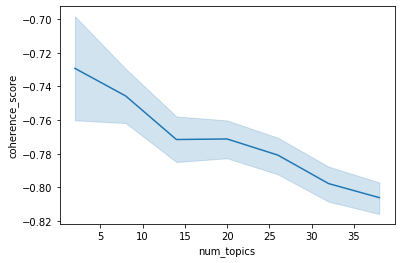

In [87]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [88]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: ignored

In [0]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.02226036),
 (1, 0.022260414),
 (2, 0.022260347),
 (3, 0.022260347),
 (4, 0.022260392),
 (5, 0.0222604),
 (6, 0.022260347),
 (7, 0.35487327),
 (8, 0.022260398),
 (9, 0.022260517),
 (10, 0.022260416),
 (11, 0.022260422),
 (12, 0.3557417),
 (13, 0.022260347),
 (14, 0.022260347)]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [0]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [0]:
test = "Ned asked me a question about England today."

In [0]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [0]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [0]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [0]:
people = get_people(doc_stream(path))

In [0]:
doc = nlp(next(doc_stream(path)))

In [0]:
doc.ents[0].lemma_

'yesterday'

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)